In [7]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
warpSize = 32
blockSize = 1024

In [13]:
# traveling wave at eccentricity of 1.8 and 3.4 deg, Wilson et al 2001 Nat
E0 = 0
max_ecc = 2 #deg 
E1 = max_ecc
#darea = lambda E: 103*(0.82+E)**(-2.28) # mm^2/deg # Van Essen 1984 Vision Research
#darea = lambda E: 855.31*(2.3438+E)**(-2.6245) # JG Malpeli et al 1996 (combined Van Essen 1984, Hubel and Freeman 1977, Tootell et al 1982)
darea = lambda E: 140*(0.78+E)**(-2.2) # Van Essen 1984 Vision Research "standard" map
area_slice = lambda E: np.pi*E*darea(E)
den_area = 850 # mm^2 O'Kusky 1982 for the neuronal density we use later  
r = integrate.quad(area_slice,0,90)
v1_size = r[0]
print("v1 size calculated by integrating the CMF from 0 to 90 eccentricity", v1_size)
r = integrate.quad(area_slice,E0,E1)
area = r[0]
print("simulating a patch of v1 starting from eccentricity of", E0, "to", E1, "of size", area)
print('ratio = ', area/v1_size)
area = area/v1_size * den_area
print('using area', area)

v1 size calculated by integrating the CMF from 0 to 90 eccentricity 1034.654752772809
simulating a patch of v1 starting from eccentricity of 0 to 2 of size 217.36359970075964
ratio =  0.21008321772865685
using area 178.5707350693583


In [14]:
import math

## O'Kusky 1982; Kelly & Hawken 2017; M.Schmidt 2018, assuming constant density near the fovea
surface_den_L4Cbeta = 30000 # per mm^2
n_L4Cbeta = area*surface_den_L4Cbeta # 32^4 * 10 ~ 10.4 million
surface_den_L23 = 18000 # per mm^2
n_L23 = area*surface_den_L23
print(n_L4Cbeta, (n_L4Cbeta+blockSize-1)//blockSize*blockSize)
print(n_L23, (n_L23+blockSize-1)//blockSize*blockSize)

5357122.0520807495 5357568.0
3214273.2312484495 3214336.0


In [7]:
103*(0.82+5)**(-2.28)

1.8570039165735588

In [15]:
# for test 1/80 of final size
from macaque_fovea import *
from construct import *

taking up 122.6251220703125 Mb
area 178.57073506935828 = 49.572483021822585 + 22.604126231555803 + 106.39412581597989
area per block = 0.0341304921769
characteristic_length, cl = 0.184744396875
left nblock: 1688, right nblock: 3544
cos(theta) of 1.0
modulus of ring =  -0.0824957168141
corrected cl =  0.184372674401 nring = 41
avg iterations = 6.097560975609756
avg biterations = 11.75609756097561
3544 blocks constructed
upper estimate 37 stripes
stripe #29 forced to contain 56.23591198152463 blocks
29 lines top, 834.5876944108725 blocks, total 1688 blocks
individual blocks constructed
avg iterations 20.548387096774192
5214 constructed


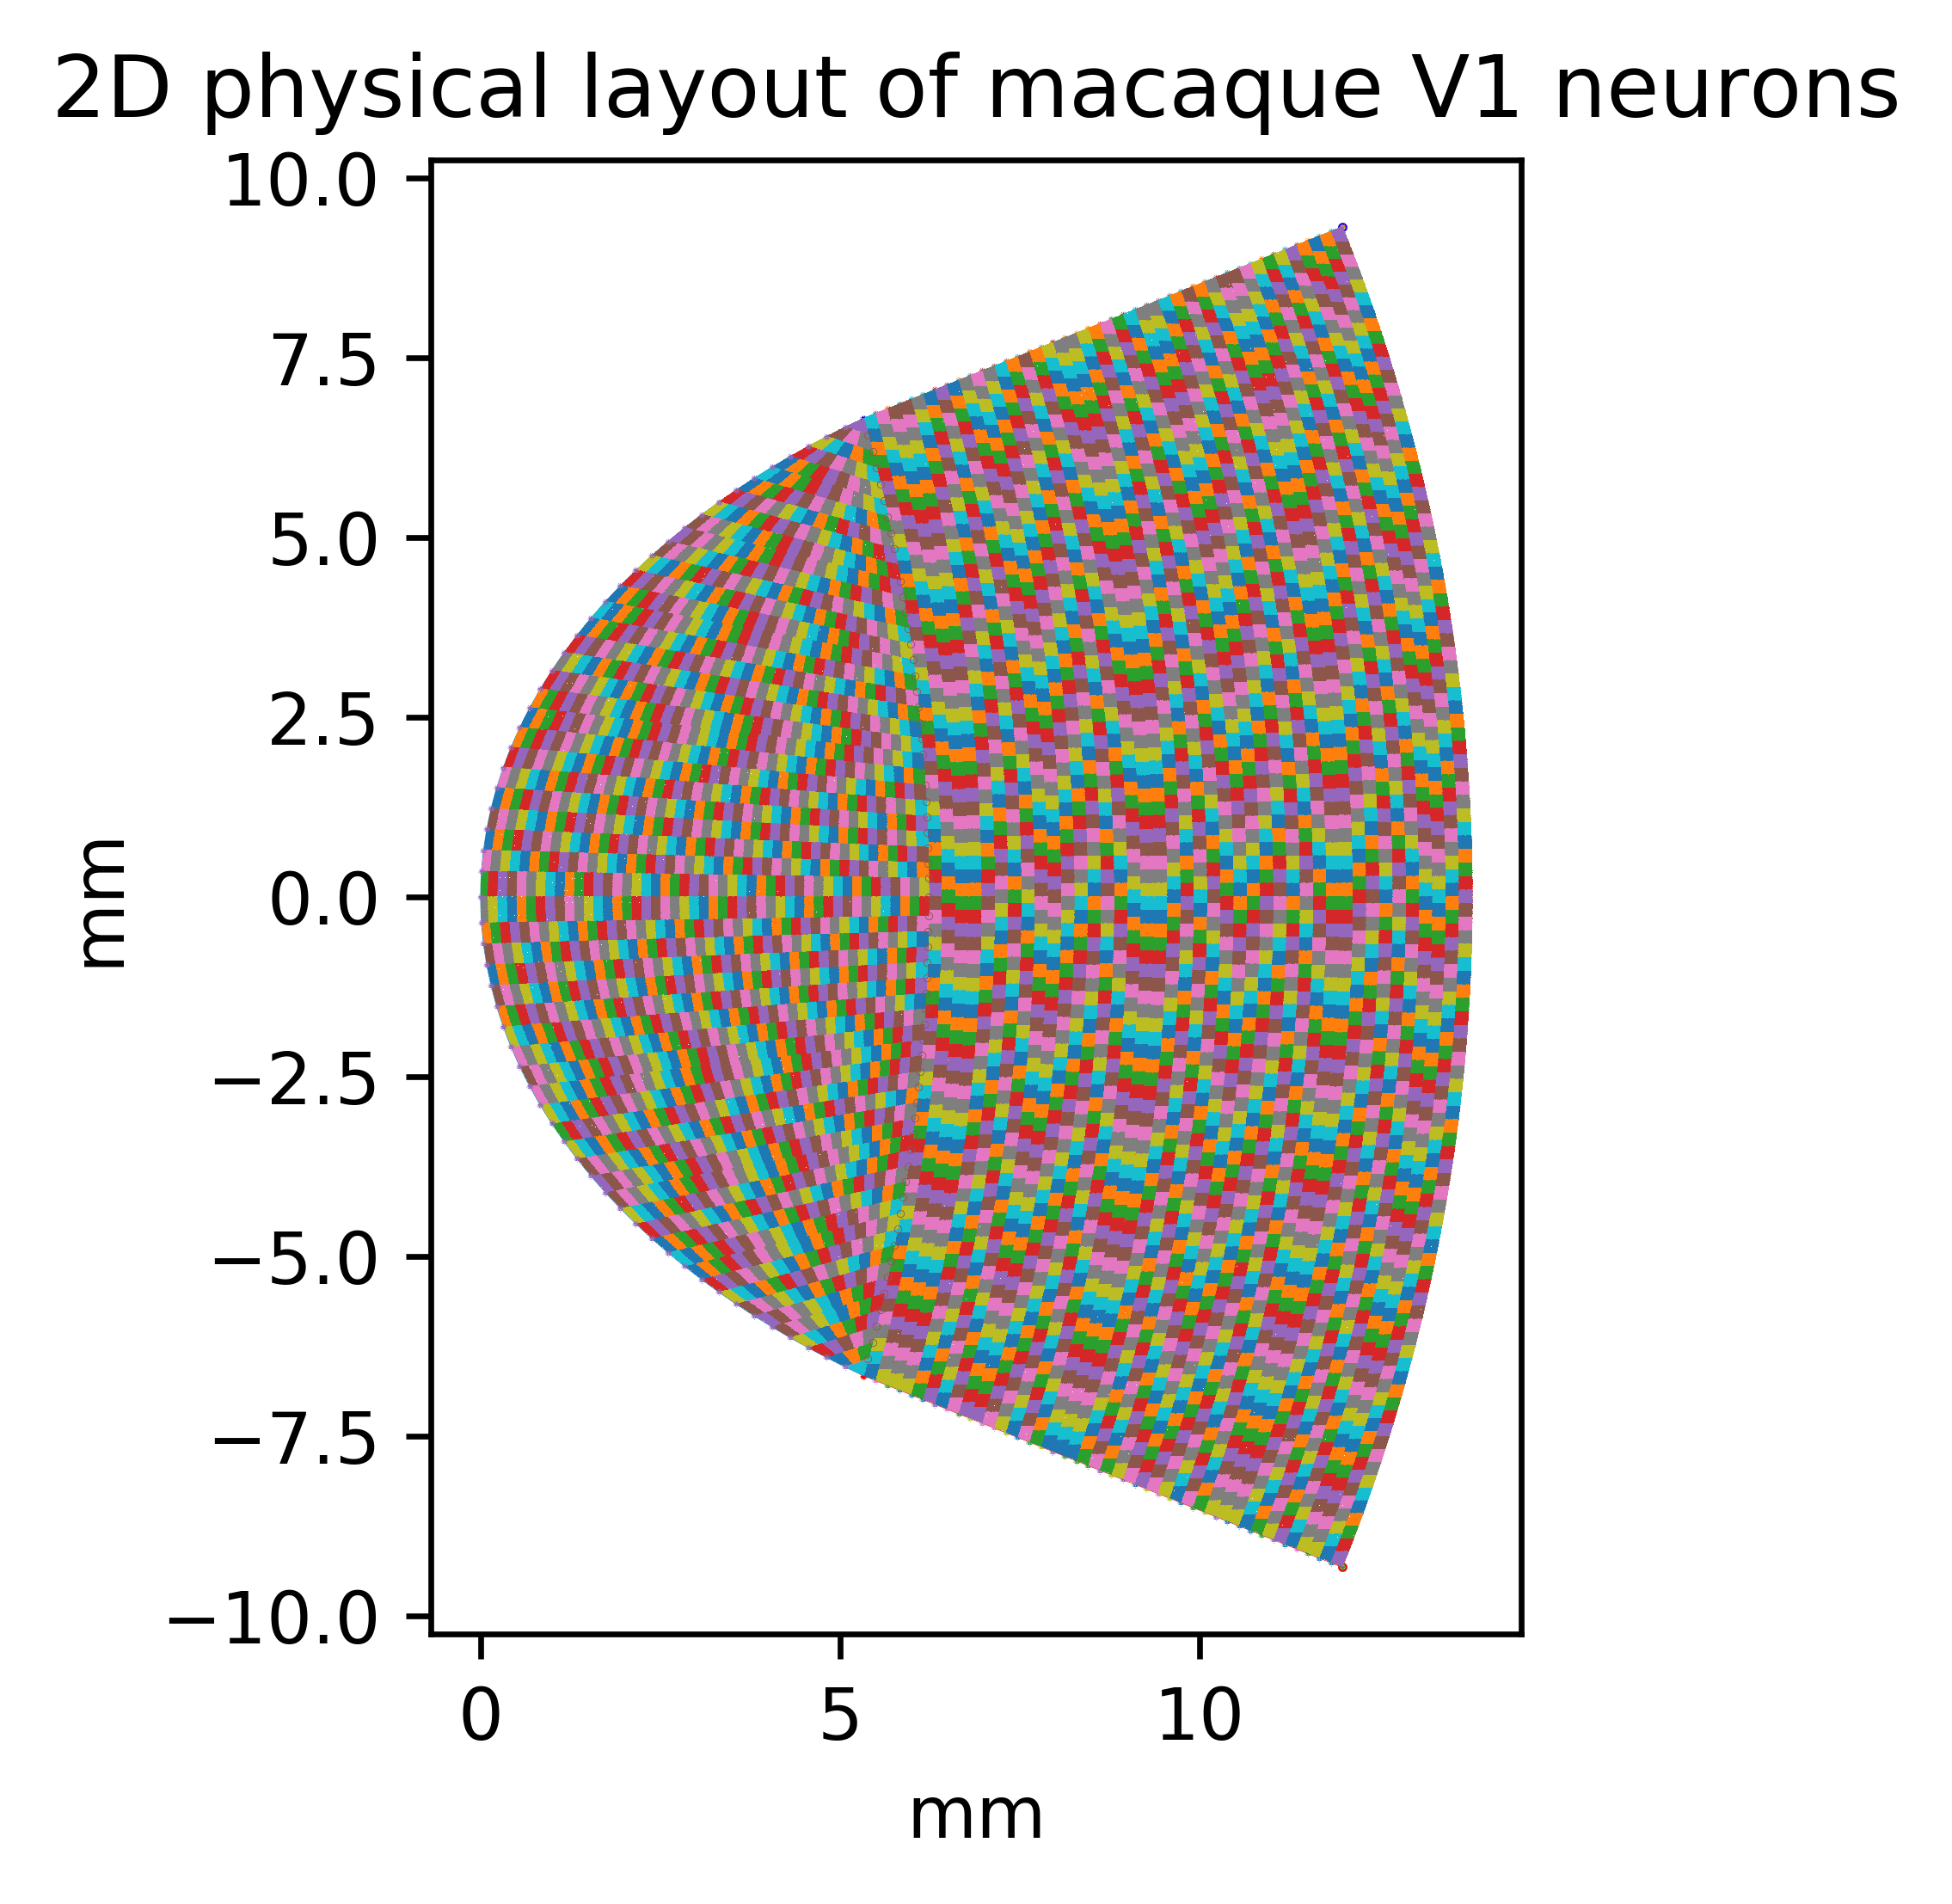

In [16]:
nblock = 5232
neuron_per_block = 1024
seed = 34576823
pos, fig = construct_macaque_fovea(area, nblock, neuron_per_block, seed, use_sobol3d=True) #sobol3d is cpu-implemented, slow

In [17]:
fig.savefig('full_density.png', dpi = 600)

In [18]:
pos.tofile('macaque_fovea_v1_3d_pos.bin')

In [30]:
nblock = 4096
neuron_per_block = 1024
seed = 34576823

taking up 96.0001220703125 Mb
area = 128.0 area per block = 0.03125
characteristic_length, cl = 0.176776695297
96 4000
cos(theta) of 0.9908301680442989
modulus of ring =  -0.327367101098
corrected cl =  0.177289508872 nring = 52
avg iterations = 6.461538461538462
avg biterations = 12.192307692307692
4000 blocks constructed
upper estimate 18 stripes
#13 limited to 3.9999999999997655
13 48.0 96
avg iterations 8.0
4096 constructed


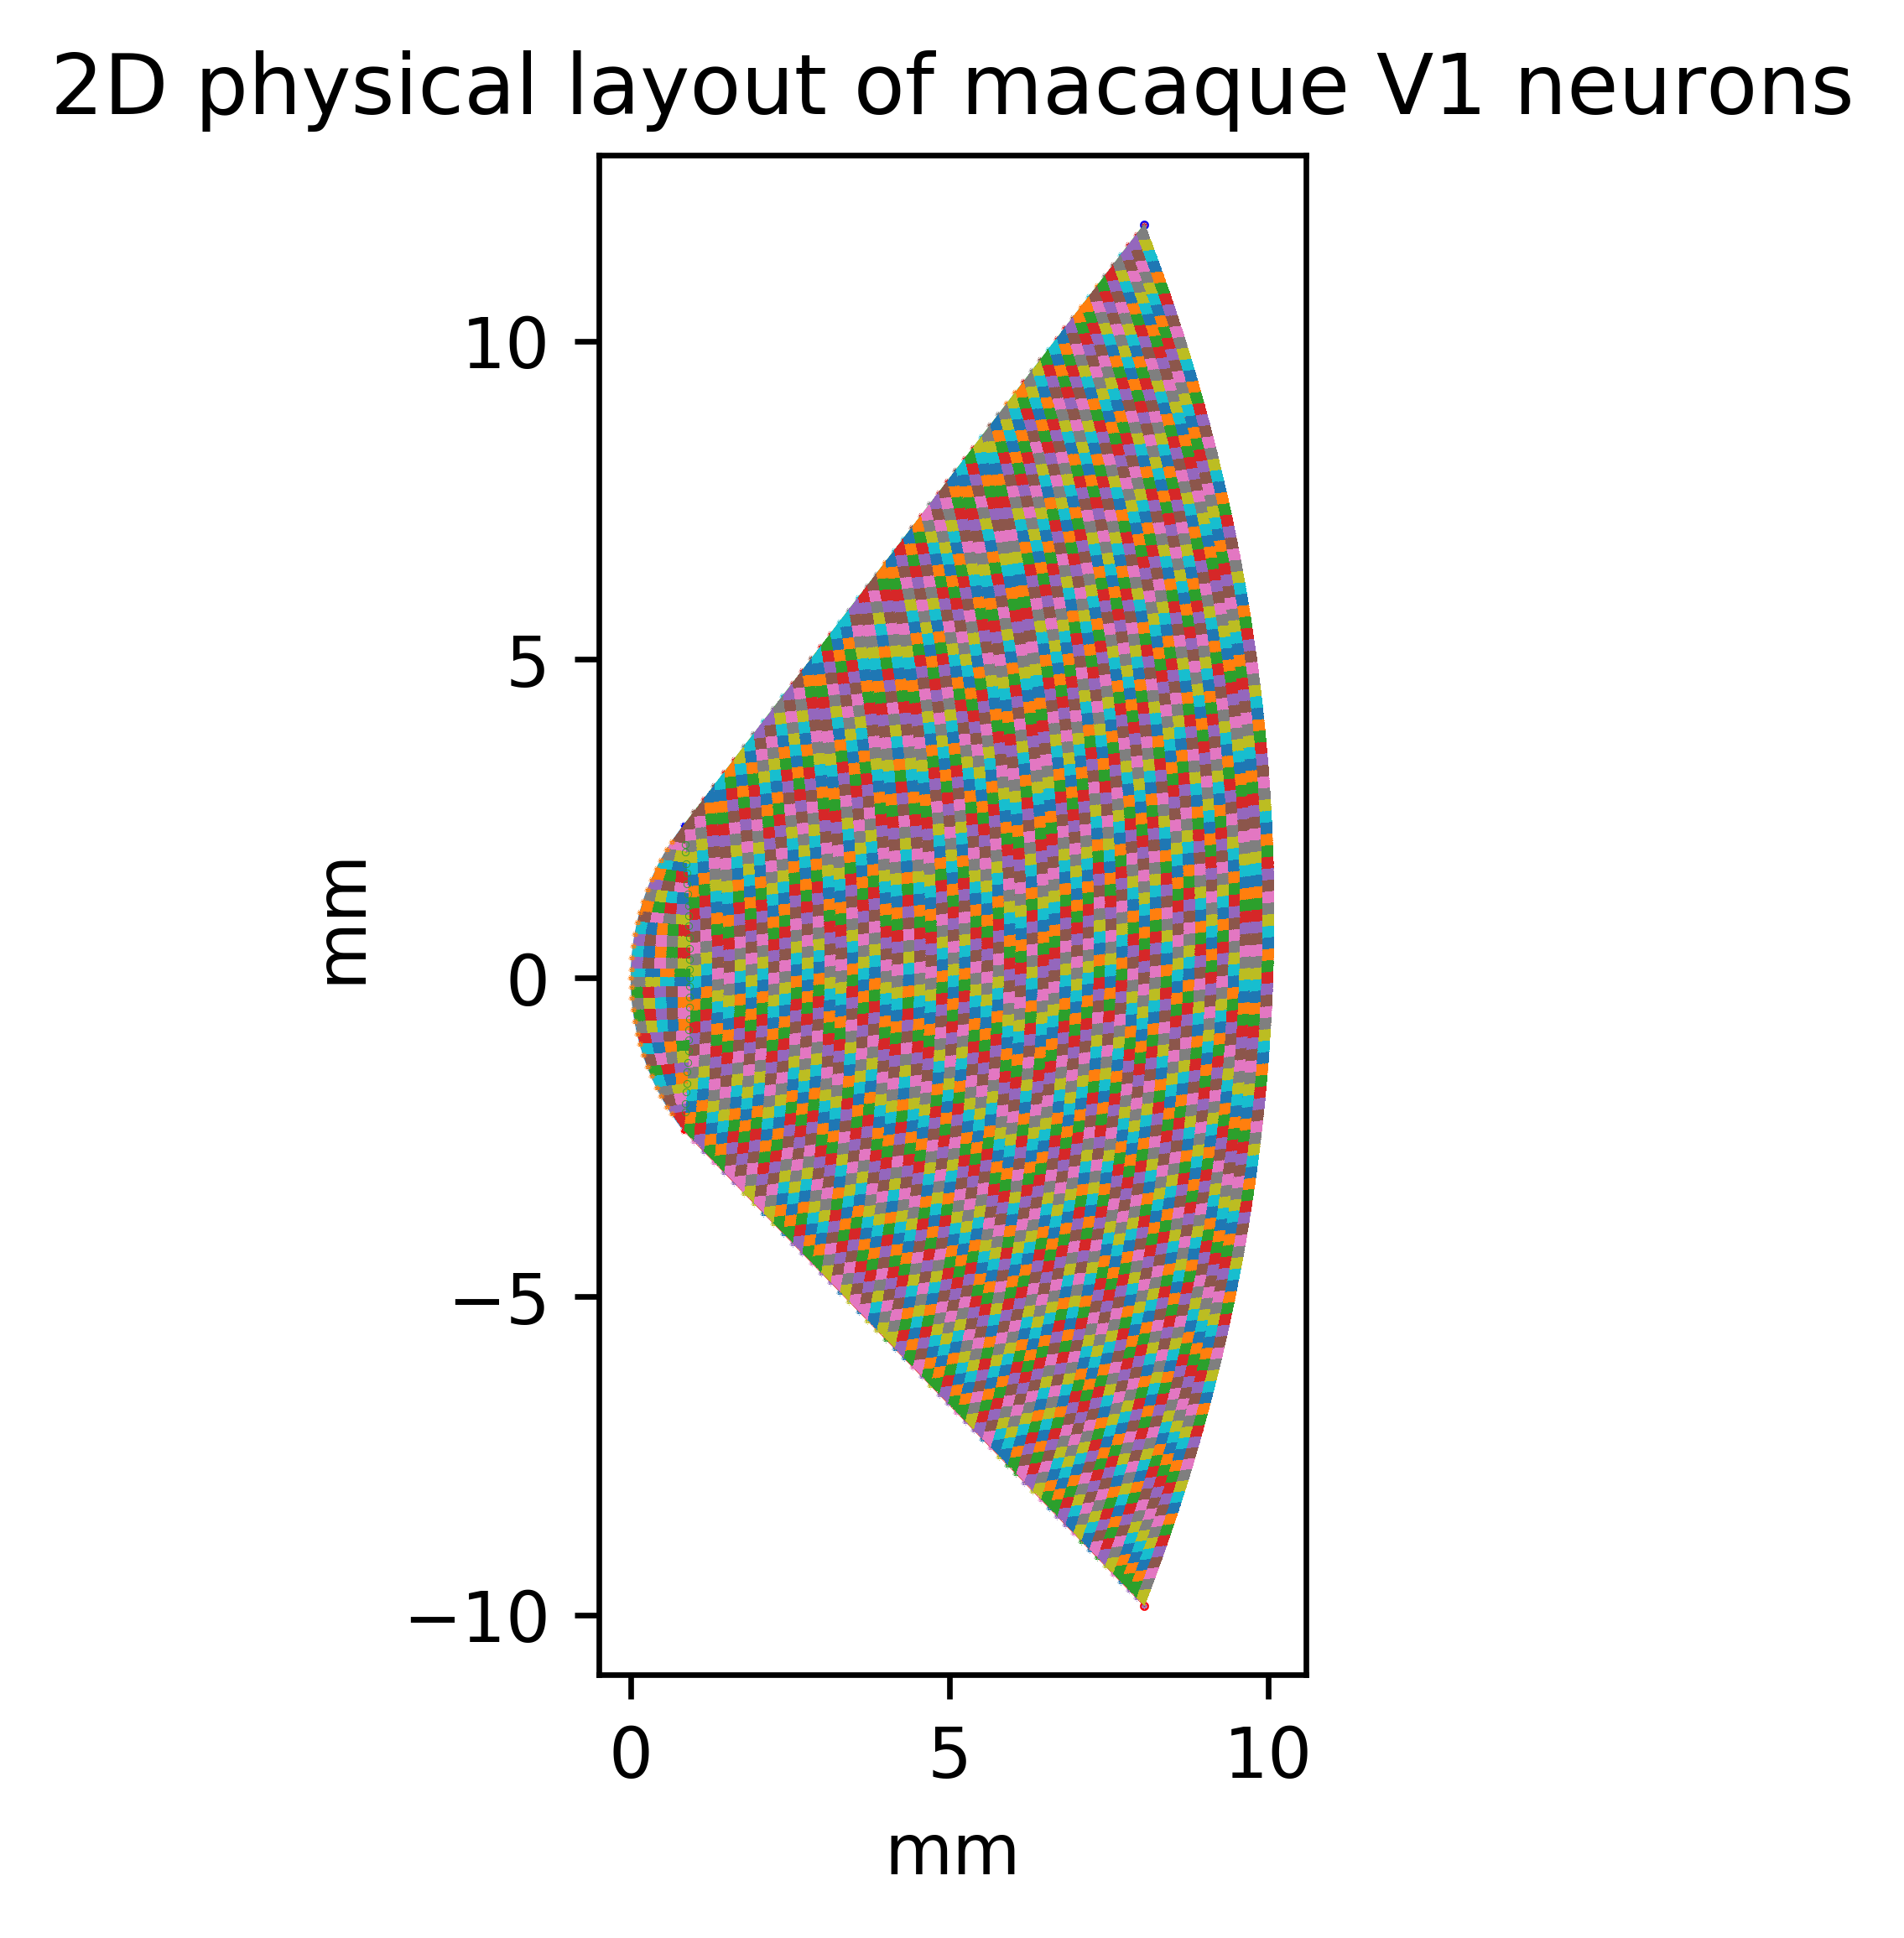

In [31]:
pos, fig = construct_macaque_fovea(area, nblock, neuron_per_block, seed, use_sobol3d=True)

In [32]:
pos.tofile('full_macaque_fovea_v1_3d_pos.bin')

In [ ]:
fig.savefig('shape.png', dpi = 600)

characteristic length =

In [20]:
cl = np.sqrt(area_CMF/10240) * 1000
print(cl)

176.7766952966369


~177x177x100 $\mu m^3$ (1024 neurons) per block, average inter-neuron(soma)-distance =

In [22]:
md = np.power(cl*cl*100/1024,1/3)
print(md)

14.504965105039933


conduction velocity ~ 1m/s, being unmylineated horizontal connections  
(0.3m/s for L2/3 and upper L4) <i>Girard et al J Neurophysiol 2001</i>  
minmum delay = 0.0145ms, no spike-correction is needed for time step (dt) < minimum delay
100Hz instantaneous firing rate, 1000 connections leads to ~ 100 spikes per time step, an effective dt of 0.01ms regardless of preset dt

In [24]:
nob = 1000/cl
print(nob)

5.65685424949238


dt = 1ms means neurons in the nearest 5~6 blocks needs to be considered for spike correction  
dt = 0.125ms (1/8) suffice for spike correction within block, #ASSUMPTION# nearfield spike correction only (neurons at block boundarys are neglected) spikes send to the other blocks are resolved after the current step.

#dt = 0.125ms is thus limited by the number of threads per block in NVIDIA GPU  
To further increase dt, will need a cross block spike-correction with CPU, or wait for an update from NVIDIA, otherwise results in an extra increase in spike-correction error, maybe tolerable.

In [34]:
time = 500
dt = 0.0625
batch_time_per_dt = 500e-6 #sec
nstep = time//dt
blocks = 10240
resident_blocks = 8
time_cost = np.int(blocks/resident_blocks) * batch_time_per_dt * nstep
print('simulate for', time ,'ms with dt =', dt, 'ms cost', time_cost/3600,'h')

simulate for 500 ms with dt = 0.0625 ms cost 1.4222222222222223 h


In [10]:
import sobol_seq as ss

In [39]:
pos = np.fromfile('full_macaque_fovea_v1_3d_pos.bin')

In [42]:
pos = np.reshape(pos,(3,nblock,neuron_per_block))

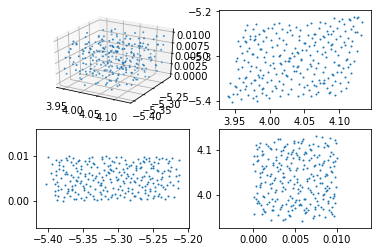

In [45]:
a = pos[:,1023,:].T
from mpl_toolkits.mplot3d import Axes3D
p0 = 768
p1 = 1024
fig = plt.figure('x')
ax = fig.add_subplot(221, projection='3d')
ax.scatter(a[p0:p1,0],a[p0:p1,1],a[p0:p1,2],s=1,zdir='z')
ax = fig.add_subplot(222)
ax.scatter(a[p0:p1,0],a[p0:p1,1], s=1)
ax = fig.add_subplot(223)
ax.scatter(a[p0:p1,1],a[p0:p1,2], s=1)
ax = fig.add_subplot(224)
ax.scatter(a[p0:p1,2],a[p0:p1,0], s=1)

In [1]:
def area(raxn, rden, d):
    area = np.zeros(d.size)
    minr = max(raxn,rden) - min(raxn,rden)
    maxr = max(raxn,rden) + min(raxn,rden)
    area[d <= minr] = np.power(min(raxn,rden),2)*np.pi
    mid_pick = np.logical_and(minr < d, d < maxr)
    d_mid = d[mid_pick]
    cos_theta_axn = (raxn*raxn + d_mid*d_mid - rden*rden)/(2*raxn*d_mid)
    cos_theta_den = (rden*rden + d_mid*d_mid - raxn*raxn)/(2*rden*d_mid)
    seg_axn = np.arccos(cos_theta_axn)*raxn*raxn
    seg_den = np.arccos(cos_theta_den)*rden*rden

    chord_axn = np.sqrt(raxn*raxn - np.power(cos_theta_axn*raxn,2)) * raxn * cos_theta_axn
    chord_den = np.sqrt(rden*rden - np.power(cos_theta_den*rden,2)) * rden * cos_theta_den
    area[mid_pick] = seg_axn+seg_den-chord_axn-chord_den
    assert(np.sum(area<0) == 0)
    return area

def base(raxn, rden, d):
    #subr = d-raxn
    #subr[subr<0] = 0
    #supr = d+raxn
    #supr[supr>rden] = rden
    #base = np.pi*(np.power(supr,2) - np.power(subr,2))
    base = np.pi*(np.power(raxn,2))
    return base

(12.5, 150.0)

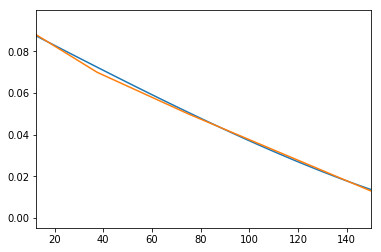

In [5]:
raxn = 100 #um
rden = 100
nd = 100
dd = (raxn+rden)/nd
dee = np.linspace(0,raxn+rden-dd,nd-1)

fig = plt.figure('prob')
ax = fig.add_subplot(111)
ratio = 0.095
ax.plot(dee,  area(raxn,rden,dee)/base(raxn,rden,dee)*ratio)
x = np.array([12.5, 37.5, 75, 150])
y = np.array([8.8, 7.0, 5.0, 1.3])/100
ax.plot(x,y)
ax.set_xlim(x[0],x[-1])

(12.5, 75)

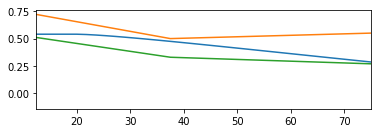

In [6]:
raxn = 100
rden = 80
nd = 100
dd = (raxn+rden)/nd
dii = np.linspace(0, raxn+rden-dd,nd-1)
fig = plt.figure('prob')
ax = fig.add_subplot(211)
y = area(raxn,rden,dii)/base(raxn,rden,dii)
baseline = -0.1
ratio = 1
ax.plot(dii,y*ratio+baseline)
x = [12.5, 37.5, 75]
y = [0.72, 0.50, 0.55]
yr = [0.51, 0.33, 0.27]
ax.plot(x,y)
ax.plot(x,yr)
ax.set_xlim(x[0],x[-1])

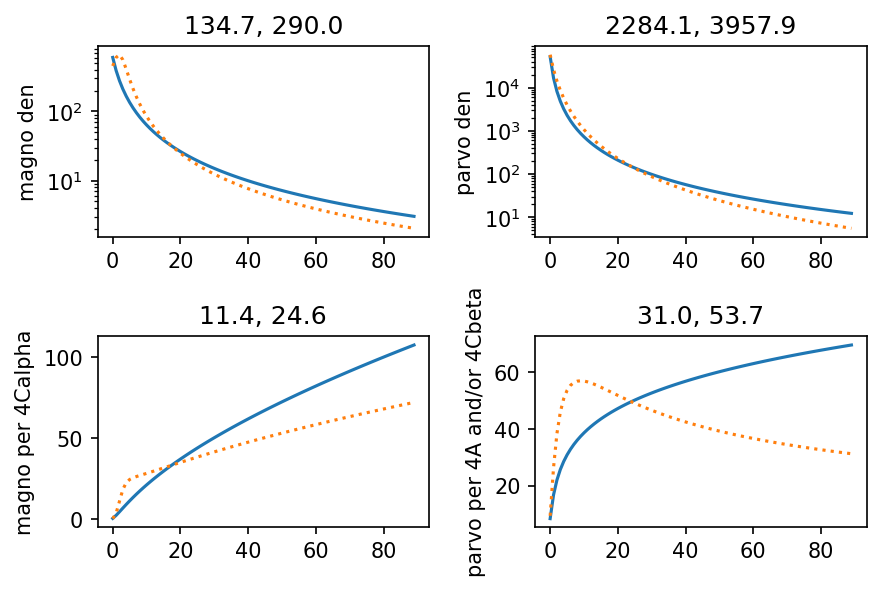

In [50]:
#Connelly-Van_Essen-1984 
Ap = 8.37
Bp = 1.28
Cp = -1.96
parvo_den = lambda E: Ap*(E+Bp)**Cp*10000 # cells/deg^2
Am = 3.52
Bm = 3.1
Cm = -1.56
magno_den = lambda E: Am*(E+Bm)**Cm*1000# cells/deg^2
deg = 5
#consistent Maplpeli et al 1996
parvo_den_alt = lambda E: 1011688*(E+2.9144)**(-2.6798)
magno_den_alt = lambda E: 2620.2*((E-1.8322)**2+5.5638)**(-0.8012)
fig = plt.figure('lgn cell areal mf', dpi=150)
ax = fig.add_subplot(221)
ecc = np.arange(0,90)
ax.plot(ecc, magno_den(ecc))
ax.plot(ecc, magno_den_alt(ecc),':')
ax.set_title(f'{magno_den(deg):.1f}, {magno_den_alt(deg):.1f}')
ax.set_ylabel('magno den')
ax.set_yscale('log')
ax = fig.add_subplot(222)
ax.plot(ecc, parvo_den(ecc))
ax.plot(ecc, parvo_den_alt(ecc),':')
ax.set_yscale('log')
ax.set_title(f'{parvo_den(deg):.1f}, {parvo_den_alt(deg):.1f}')
ax.set_ylabel('parvo den') 
est_4Cbeta_over_4A = 0.6
magno_spread = 0.5 # micron (mean)
parvo_spread = 0.2 # micron (upper limit)
surface_den_L4Calpha = 17300
magno_spread_reach_max = surface_den_L4Calpha*magno_spread**2
parvo_spread_reach_max = surface_den_L4Cbeta*parvo_spread**2
ax = fig.add_subplot(223)
ax.plot(ecc, magno_den(ecc)/darea(ecc)*magno_spread**2)
ax.plot(ecc, magno_den_alt(ecc)/darea(ecc)*magno_spread**2, ':')
ax.set_ylabel('magno per 4Calpha')
ax.set_title(f'{magno_den(deg)/darea(deg)*magno_spread**2:.1f}, {magno_den_alt(deg)/darea(deg)*magno_spread**2:.1f}')
ax = fig.add_subplot(224)
ax.plot(ecc, parvo_den(ecc)/darea(ecc)*parvo_spread**2)
ax.plot(ecc, parvo_den_alt(ecc)/darea(ecc)*parvo_spread**2, ':')
ax.set_ylabel('parvo per 4A and/or 4Cbeta')
ax.set_title(f'{parvo_den(deg)/darea(deg)*parvo_spread**2:.1f}, {parvo_den_alt(deg)/darea(deg)*parvo_spread**2:.1f}')
plt.tight_layout()

In [35]:
fig.savefig('upper_limit_of_nLGN_per_V1.png')

In [57]:
deg = 5
p_den = lambda E: 110000*(E+1.28)**(-1.96) #cell/deg^2
m_den = lambda E: 4600*(E+3.12)**(-1.56) #cell/deg^2
print(p_den(deg),m_den(deg))
areal_cmf = lambda E: 12.2**2*(E+0.94)**(-2.0) # mm^2/deg^2
print(areal_cmf(deg))
parvo_per_p = p_den(deg)/areal_cmf(deg)
print(f'{parvo_per_p:.1f} P cells/mm^2 to 4Cbeta + 4A')
magno_per_m = m_den(deg)/areal_cmf(deg)
print(f'{magno_per_m:.1f} M cells/mm^2 to 4Calpha')

3001.8693283061225 175.32765576316365
4.218390413676609
711.6 P cells/mm^2 to 4Cbeta + 4A
41.6 M cells/mm^2 to 4Calpha


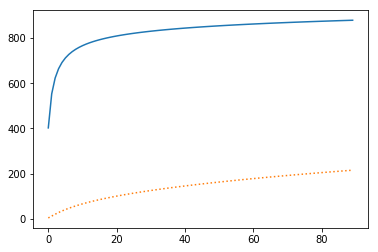

In [59]:
fig = plt.figure('Schein')
ax = fig.add_subplot(111)
ax.plot(ecc, p_den(ecc)/areal_cmf(ecc))
ax.plot(ecc, m_den(ecc)/areal_cmf(ecc),':')

In [42]:
1000/4

250.0